In [1]:
import pathlib
import os
import torch
import PIL
from PIL import Image
from torch.utils.data import Dataset
from utils import utils
from dataset.dataset import ASLDataset
from model.TwoStreamCNN import TwoStreamCNN
import torch
from torch import nn
import numpy as np
from torch.optim import Adam
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from utils import utils
from torchvision.transforms import v2
import torch 
import torch.optim as optim
from torchvision import transforms

In [2]:
import torchvision
print(torchvision.__version__)

0.16.1+cu121


In [3]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
device 

device(type='cuda', index=1)

In [4]:
transforms_tout = {
    "train" : v2.Compose([
    v2.Resize((226,226)),
    v2.RandomHorizontalFlip(), # data augmentation
    transforms.RandomRotation(degrees=45, fill=(0,)),  # Rotate by 45 degrees # Scale by 10%
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translate horizontally and vertically by 10%# Gray normalization
    v2.ToTensor(),
    v2.Grayscale(num_output_channels=1),
    v2.Normalize(mean=[0.5], std=[0.5]),
    
    ]),
    "test" : v2.Compose([
    v2.Resize((226,226)),
    v2.ToTensor(),
    v2.Grayscale(num_output_channels=1),
    v2.Normalize(mean=[0.5], std=[0.5])  # Gray normalization
    ])
}
transform = v2.Compose([
    v2.ToTensor(),
    v2.Grayscale(num_output_channels=3),
    v2.Normalize(mean=[0.5], std=[0.5])  # Gray normalization
])

/home/ibmelab/anaconda3/envs/2scnn/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [5]:
# 1. Load and transform data

train_dir = "archive/asl_alphabet_train/asl_alphabet_train"
train_data_simple = ASLDataset(data_path=train_dir,range_index = [1,2500], transform=transforms_tout["train"])
test_data_simple = ASLDataset(data_path=train_dir,range_index = [2501,3000], transform=transforms_tout["test"])

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batch size and number of workers 
BATCH_SIZE = 64
NUM_WORKERS = 8
print(f"Creating DataLoader's with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data_simple, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True, 
                                     num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(test_data_simple, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle= True, 
                                    num_workers=NUM_WORKERS)
print(f'train dataset size :{len(train_data_simple)} images ')
print(f'test dataset size :{len(test_data_simple)} images ')

Creating DataLoader's with batch size 64 and 8 workers.
train dataset size :72471 images 
test dataset size :14471 images 


In [6]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X,XN, y) in enumerate(dataloader):
        # Send data to target device
        X,XN, y = X.to(device),XN.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X,XN)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [7]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X,XN,y) in enumerate(dataloader):
            # Send data to target device
            X,XN,y = X.to(device),XN.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X,XN)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [8]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f}| "
            f"train_acc: {train_acc*100:.4f}% | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc*100:.4f}%"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

/home/ibmelab/anaconda3/envs/2scnn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 45

# Recreate an instance of TinyVGG
model_0 = TwoStreamCNN(29,type= "tsma")

model_0.to(device)
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
loss_fn.cuda()
optimizer = optim.Adam(model_0.parameters(), lr=0.00001/5,weight_decay=1e-5)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

/home/ibmelab/anaconda3/envs/2scnn/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ibmelab/anaconda3/envs/2scnn/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  2%|▏         | 1/45 [09:37<7:03:29, 577.48s/it]

Epoch: 1 | train_loss: 3.2814| train_acc: 17.0591% | test_loss: 3.1939 | test_acc: 25.7444%


  4%|▍         | 2/45 [19:14<6:53:39, 577.19s/it]

Epoch: 2 | train_loss: 3.0716| train_acc: 36.9478% | test_loss: 3.0717 | test_acc: 35.8854%


  7%|▋         | 3/45 [28:52<6:44:17, 577.55s/it]

Epoch: 3 | train_loss: 2.9032| train_acc: 55.1147% | test_loss: 2.9579 | test_acc: 49.6322%


  9%|▉         | 4/45 [38:30<6:34:47, 577.74s/it]

Epoch: 4 | train_loss: 2.7195| train_acc: 73.3518% | test_loss: 2.8887 | test_acc: 57.3966%


 11%|█         | 5/45 [48:07<6:24:52, 577.30s/it]

Epoch: 5 | train_loss: 2.5987| train_acc: 85.1730% | test_loss: 2.8409 | test_acc: 61.5540%


 13%|█▎        | 6/45 [57:45<6:15:30, 577.71s/it]

Epoch: 6 | train_loss: 2.5307| train_acc: 91.3590% | test_loss: 2.8544 | test_acc: 59.7713%


 16%|█▌        | 7/45 [1:07:24<6:06:02, 577.97s/it]

Epoch: 7 | train_loss: 2.4817| train_acc: 95.4593% | test_loss: 2.8130 | test_acc: 63.5492%


 18%|█▊        | 8/45 [1:17:01<5:56:25, 577.97s/it]

Epoch: 8 | train_loss: 2.4603| train_acc: 97.4321% | test_loss: 2.8261 | test_acc: 61.9307%


 20%|██        | 9/45 [1:26:39<5:46:43, 577.87s/it]

Epoch: 9 | train_loss: 2.4389| train_acc: 99.2498% | test_loss: 2.8006 | test_acc: 64.4263%


 22%|██▏       | 10/45 [1:36:18<5:37:13, 578.10s/it]

Epoch: 10 | train_loss: 2.4344| train_acc: 99.4539% | test_loss: 2.7913 | test_acc: 64.7282%


 24%|██▍       | 11/45 [1:45:56<5:27:39, 578.22s/it]

Epoch: 11 | train_loss: 2.4319| train_acc: 99.5987% | test_loss: 2.7922 | test_acc: 64.2798%


 27%|██▋       | 12/45 [1:55:33<5:17:50, 577.91s/it]

Epoch: 12 | train_loss: 2.4306| train_acc: 99.6428% | test_loss: 2.8005 | test_acc: 63.9337%


 29%|██▉       | 13/45 [2:05:11<5:08:14, 577.95s/it]

Epoch: 13 | train_loss: 2.4295| train_acc: 99.7242% | test_loss: 2.7997 | test_acc: 63.6584%


 31%|███       | 14/45 [2:14:50<4:58:41, 578.12s/it]

Epoch: 14 | train_loss: 2.4289| train_acc: 99.7531% | test_loss: 2.7860 | test_acc: 64.5768%


 33%|███▎      | 15/45 [2:24:28<4:49:00, 578.02s/it]

Epoch: 15 | train_loss: 2.4282| train_acc: 99.7838% | test_loss: 2.7890 | test_acc: 64.7213%


 36%|███▌      | 16/45 [2:34:04<4:39:10, 577.61s/it]

Epoch: 16 | train_loss: 2.4278| train_acc: 99.8249% | test_loss: 2.7762 | test_acc: 65.5483%


 38%|███▊      | 17/45 [2:43:43<4:29:44, 578.00s/it]

Epoch: 17 | train_loss: 2.4275| train_acc: 99.8276% | test_loss: 2.7734 | test_acc: 66.1265%


 40%|████      | 18/45 [2:53:22<4:20:10, 578.16s/it]

Epoch: 18 | train_loss: 2.4272| train_acc: 99.8524% | test_loss: 2.7774 | test_acc: 65.4441%


 42%|████▏     | 19/45 [3:02:59<4:10:27, 577.99s/it]

Epoch: 19 | train_loss: 2.4269| train_acc: 99.8731% | test_loss: 2.7561 | test_acc: 67.6202%


 44%|████▍     | 20/45 [3:12:37<4:00:46, 577.88s/it]

Epoch: 20 | train_loss: 2.4269| train_acc: 99.8635% | test_loss: 2.7719 | test_acc: 66.4697%


 47%|████▋     | 21/45 [3:22:16<3:51:13, 578.08s/it]

Epoch: 21 | train_loss: 2.4269| train_acc: 99.8621% | test_loss: 2.7817 | test_acc: 65.6909%


 49%|████▉     | 22/45 [3:31:54<3:41:34, 578.03s/it]

Epoch: 22 | train_loss: 2.4265| train_acc: 99.8924% | test_loss: 2.7504 | test_acc: 68.5730%


 51%|█████     | 23/45 [3:41:31<3:31:50, 577.73s/it]

Epoch: 23 | train_loss: 2.4265| train_acc: 99.8883% | test_loss: 2.7530 | test_acc: 68.5002%


 53%|█████▎    | 24/45 [3:51:09<3:22:17, 578.00s/it]

Epoch: 24 | train_loss: 2.4264| train_acc: 99.8911% | test_loss: 2.7699 | test_acc: 66.8492%


 56%|█████▌    | 25/45 [4:00:48<3:12:43, 578.19s/it]

Epoch: 25 | train_loss: 2.4266| train_acc: 99.8662% | test_loss: 2.7473 | test_acc: 69.0450%


 58%|█████▊    | 26/45 [4:10:25<3:03:00, 577.95s/it]

Epoch: 26 | train_loss: 2.4260| train_acc: 99.9242% | test_loss: 2.7622 | test_acc: 67.7165%


 60%|██████    | 27/45 [4:20:03<2:53:21, 577.85s/it]

Epoch: 27 | train_loss: 2.4262| train_acc: 99.8993% | test_loss: 2.7644 | test_acc: 67.1649%


 62%|██████▏   | 28/45 [4:29:41<2:43:45, 577.97s/it]

Epoch: 28 | train_loss: 2.4261| train_acc: 99.9145% | test_loss: 2.7572 | test_acc: 67.9220%


 64%|██████▍   | 29/45 [4:39:19<2:34:08, 578.01s/it]

Epoch: 29 | train_loss: 2.4262| train_acc: 99.9062% | test_loss: 2.7512 | test_acc: 68.6802%


 67%|██████▋   | 30/45 [4:48:56<2:24:25, 577.67s/it]

Epoch: 30 | train_loss: 2.4258| train_acc: 99.9435% | test_loss: 2.7762 | test_acc: 65.5749%


 69%|██████▉   | 31/45 [4:58:34<2:14:49, 577.84s/it]

Epoch: 31 | train_loss: 2.4257| train_acc: 99.9504% | test_loss: 2.7076 | test_acc: 73.0501%


 71%|███████   | 32/45 [5:08:13<2:05:14, 578.02s/it]

Epoch: 32 | train_loss: 2.4257| train_acc: 99.9448% | test_loss: 2.7430 | test_acc: 68.6448%


 73%|███████▎  | 33/45 [5:17:50<1:55:34, 577.88s/it]

Epoch: 33 | train_loss: 2.4258| train_acc: 99.9255% | test_loss: 2.7491 | test_acc: 68.2603%


 76%|███████▌  | 34/45 [5:27:28<1:45:57, 577.96s/it]

Epoch: 34 | train_loss: 2.4260| train_acc: 99.9131% | test_loss: 2.7586 | test_acc: 67.2465%


 78%|███████▊  | 35/45 [5:37:07<1:36:20, 578.01s/it]

Epoch: 35 | train_loss: 2.4258| train_acc: 99.9324% | test_loss: 2.7817 | test_acc: 64.8590%


 80%|████████  | 36/45 [5:46:46<1:26:45, 578.37s/it]

Epoch: 36 | train_loss: 2.4257| train_acc: 99.9435% | test_loss: 2.7748 | test_acc: 65.5935%


 82%|████████▏ | 37/45 [5:56:23<1:17:03, 577.89s/it]

Epoch: 37 | train_loss: 2.4260| train_acc: 99.9131% | test_loss: 2.7649 | test_acc: 66.4058%


 84%|████████▍ | 38/45 [6:06:01<1:07:27, 578.18s/it]

Epoch: 38 | train_loss: 2.4260| train_acc: 99.9131% | test_loss: 2.7555 | test_acc: 67.7696%


 87%|████████▋ | 39/45 [6:15:40<57:49, 578.29s/it]  

Epoch: 39 | train_loss: 2.4257| train_acc: 99.9366% | test_loss: 2.7655 | test_acc: 66.4136%


 89%|████████▉ | 40/45 [6:25:18<48:10, 578.18s/it]

Epoch: 40 | train_loss: 2.4258| train_acc: 99.9269% | test_loss: 2.7472 | test_acc: 68.1217%


 91%|█████████ | 41/45 [6:34:55<38:31, 577.94s/it]

Epoch: 41 | train_loss: 2.4256| train_acc: 99.9490% | test_loss: 2.7471 | test_acc: 68.2672%


 93%|█████████▎| 42/45 [6:44:33<28:54, 578.01s/it]

Epoch: 42 | train_loss: 2.4257| train_acc: 99.9338% | test_loss: 2.7463 | test_acc: 68.5878%


 96%|█████████▌| 43/45 [6:54:12<19:16, 578.11s/it]

Epoch: 43 | train_loss: 2.4256| train_acc: 99.9462% | test_loss: 2.7004 | test_acc: 73.3195%


 98%|█████████▊| 44/45 [7:03:48<09:37, 577.67s/it]

Epoch: 44 | train_loss: 2.4254| train_acc: 99.9614% | test_loss: 2.7230 | test_acc: 70.6635%


100%|██████████| 45/45 [7:13:27<00:00, 577.94s/it]

Epoch: 45 | train_loss: 2.4256| train_acc: 99.9379% | test_loss: 2.7376 | test_acc: 69.4305%
Total training time: 26007.369 seconds


In [10]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [11]:
import csv 
csv_filename = 'modelRESNET50_10_6_results_weightdecay.csv'
header = list(model_0_results.keys())
with open(csv_filename, 'w', newline='') as csvfile:
    # Create a CSV writer object
    csv_writer = csv.writer(csvfile)

    # Write the header row with the keys
    csv_writer.writerow(['Iteration'] + header)

    # Write the data for each iteration
    for i, iteration in enumerate(zip(*model_0_results.values())):
        csv_writer.writerow([i + 1] + list(iteration))

print(f"Results written to {csv_filename}")

Results written to modelRESNET50_10_6_results_weightdecay.csv


In [12]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();

In [13]:
import matplotlib.pyplot as plt

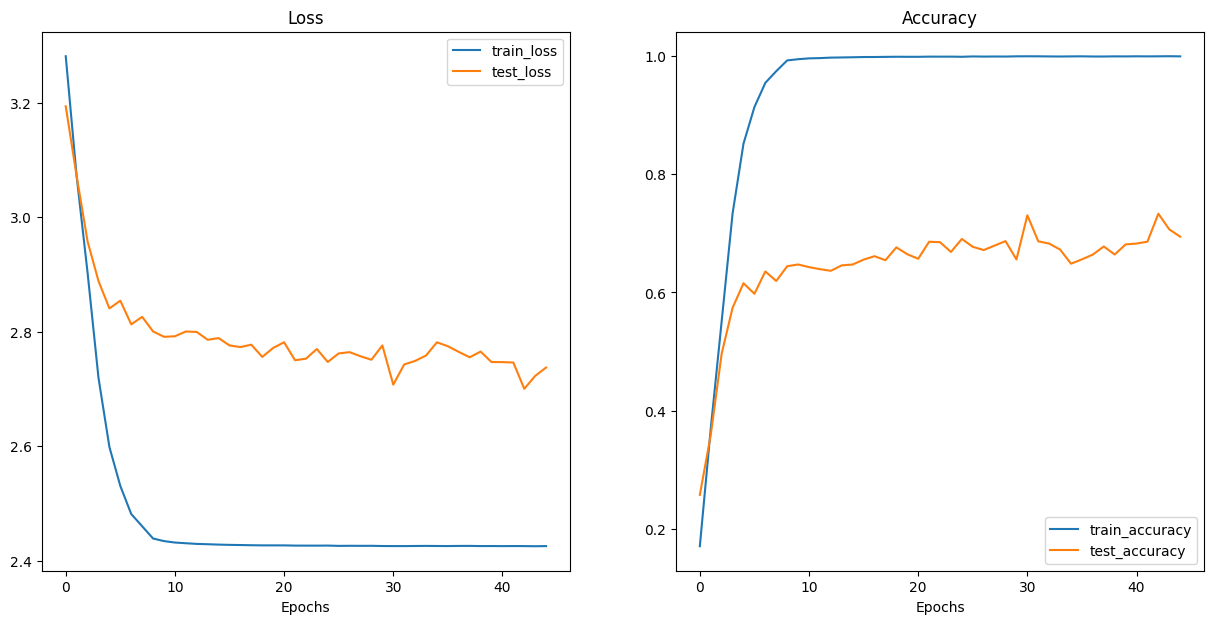

In [14]:
plot_loss_curves(model_0_results)